In [1]:
import gzip
import numpy as np
#get the indices of the positives
threshold_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/fineFactorized/task_273-naivegw/NaiveauPRC.txt"
calibrated_threshold = float(open(threshold_file).read().split("\n")[1].split("\t")[1])
peak_regions_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/fineFactorized/task_273-naivegw/predictions/task_273-NaiveSummit.calibrated.full_mouse50.tab.gz"
filtered_examples_mask = (np.array([float(x.decode("utf-8").split("\t")[5])
                           for x in gzip.open(peak_regions_file, 'rb')])
                           > calibrated_threshold)

In [2]:
import h5py
deeplift_scores_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/Naive_deeplift2019/task_273-naivegw/summit.h5"
f = h5py.File(deeplift_scores_file,"r")
hyp_scores = np.array(f['deeplift_scores'][:])[filtered_examples_mask]
sequence_onehot = np.array(f['inputs'][:])[filtered_examples_mask]
imp_scores = sequence_onehot*hyp_scores

In [3]:
TAL1_hocomoco_pwm = np.array([
[float(x) for x in row.split("\t")] for row in
"""-0.1534218054606978	0.4248884005542006	0.03874842366748681	-0.5563400288274302
0.6464252650829619	-0.19096598877289345	-0.4517428977281205	-0.46423468265484735
0.09778278471982192	-1.7701210752371432	0.6587683755978941	-0.22997490888551778
-0.3570577390357126	0.015679997751073114	0.6949091007770549	-1.2696234647115647
0.7960986345594286	-0.1534218054606978	-0.9376103830414496	-0.6277442179623938
0.8847264425178556	-2.2340103118057417	-0.14425194284148976	-0.5026745162600582
0.46041545716766114	-0.7879487534832245	0.6505565864406581	-3.1262106111200567
-1.9199997006100191	1.3217083373824634	-2.694308015795771	-3.324736791140142
1.3068477609048863	-3.903141843818025	-3.324736791140142	-1.3889770090864402
-2.8186351867496584	-1.2418852451298863	1.229040024674195	-1.454459020739145
0.4453438583421999	0.3272783608001891	-0.14425194284148976	-1.6813854611337156
-1.2418852451298863	-2.9606438896517475	-2.2340103118057417	1.2675888612037503
-1.8176277056823105	-2.694308015795771	1.2496331898723319	-1.2696234647115647
-1.000060890477635	-0.6887818819947552	0.3215658109169486	0.5599984365563851
-0.7537887239776389	-0.03211743511552166	0.274651146968163	0.21909970310567795""".split("\n")])

TF-MoDISco is using the TensorFlow backend.


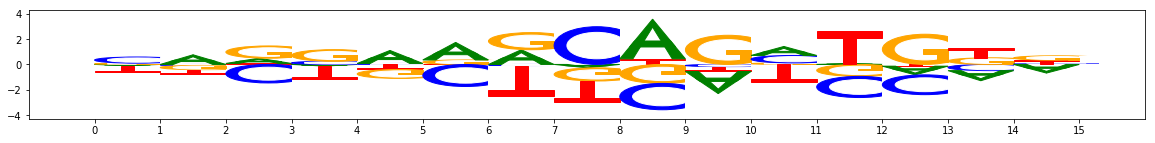

In [4]:
%matplotlib inline
from modisco.visualization import viz_sequence
viz_sequence.plot_weights(TAL1_hocomoco_pwm-np.mean(TAL1_hocomoco_pwm,axis=-1)[:,None])

In [6]:
import modisco
modisco_file = "/oak/stanford/groups/akundaje/msharmin/mouse_hem/from_labcluster/with_tfd/full_mouse50/Naive_modisco2019/task_273-naivegw/results.hdf5"
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task"],
                contrib_scores={"task": imp_scores},
                hypothetical_contribs={"task": hyp_scores},
                one_hot=sequence_onehot)
grp = h5py.File(modisco_file,"r")
tfmodisco_results =\
    modisco.tfmodisco_workflow.workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

In [7]:
from collections import defaultdict
coords = (tfmodisco_results.multitask_seqlet_creation_results
            .task_name_to_coord_producer_results["task"]
            .coords)
example_idx_to_coords = defaultdict(list)
for coord in coords:
    example_idx_to_coords[coord.example_idx].append(
        (coord.start, coord.end))

In [9]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def scan_deeplift_scores_with_pwm(imp_scores, pwm):
    strided_arr = rolling_window(imp_scores.transpose((0,2,1)),
                                 window=len(pwm)).transpose((0,2,3,1))
    #report both the sum and the cosine similarity
    #this finds the sum
    sum_scores = np.sum(strided_arr, axis=(2,3))
    #this finds the cosine similarity with a masked version of the pwm
    # where only the positions that are nonzero in the deeplift scores are
    # considered
    dot_product_pwm = np.sum(strided_arr*pwm[None,None,:,:], axis=(2,3))
    norm_deeplift_scores = np.sqrt(np.sum(np.square(strided_arr), axis=(2,3)))
    norm_masked_pwm = np.sqrt(np.sum(np.square((np.abs(strided_arr)>0)*pwm[None,None,:,:]), axis=(2,3)))
    cosine_sim = dot_product_pwm/(norm_deeplift_scores*norm_masked_pwm)
    return sum_scores, cosine_sim

def pwm_scan(array, pwm):
    strided_arr = rolling_window(array.transpose((0,2,1)), window=len(pwm)).transpose((0,2,3,1))
    pwm_scores = np.sum(strided_arr*pwm[None,None,:,:],axis=(2,3))
    return pwm_scores

/users/avanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/users/avanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/users/avanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will

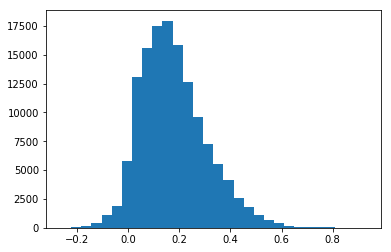

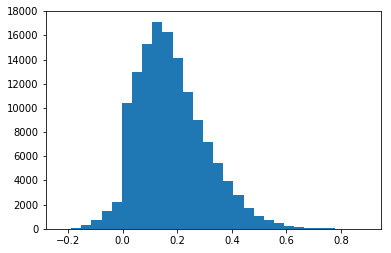

In [84]:
import gc
import time
from matplotlib import pyplot as plt

def scan_seqlets_for_pwm(seqlets, pwm, min_total_imp):
    
    fwd_imp_scores = np.concatenate([
        x["task_contrib_scores"].fwd[None,:,:] for x in seqlets],
        axis=0)
    fwd_total_imp, fwd_cosine_sim = scan_deeplift_scores_with_pwm(
            imp_scores=fwd_imp_scores,
            pwm=pwm)
    masked_fwd_cosine_sim = (
        fwd_cosine_sim*(fwd_total_imp > min_total_imp))
    
    argmax_masked_fwd_cosine_sim = np.argmax(
        masked_fwd_cosine_sim, axis=-1)
    max_masked_fwd_cosine_sim = masked_fwd_cosine_sim[[
        np.arange(len(argmax_masked_fwd_cosine_sim)),
        argmax_masked_fwd_cosine_sim]]
    totalimp_at_fwd_argmaxcosinesim = fwd_total_imp[[
        np.arange(len(argmax_masked_fwd_cosine_sim)),
        argmax_masked_fwd_cosine_sim]]
    
    rev_imp_scores = np.concatenate([
        x["task_contrib_scores"].rev[None,:,:] for x in seqlets],
        axis=0)
    rev_total_imp, rev_cosine_sim = scan_deeplift_scores_with_pwm(
            imp_scores=rev_imp_scores,
            pwm=pwm)
    masked_rev_cosine_sim = (
        rev_cosine_sim*(rev_total_imp > min_total_imp))
    
    argmax_masked_rev_cosine_sim = np.argmax(
        masked_rev_cosine_sim, axis=-1)
    max_masked_rev_cosine_sim = masked_rev_cosine_sim[
        [np.arange(len(argmax_masked_rev_cosine_sim)),
         argmax_masked_rev_cosine_sim]]
    totalimp_at_rev_argmaxcosinesim = rev_total_imp[
        [np.arange(len(argmax_masked_rev_cosine_sim)),
         argmax_masked_rev_cosine_sim]]
    
    plt.hist(max_masked_fwd_cosine_sim[np.nonzero(max_masked_fwd_cosine_sim)[0]], bins=30)
    plt.show()
    plt.hist(max_masked_rev_cosine_sim[np.nonzero(max_masked_rev_cosine_sim)[0]], bins=30)
    plt.show()
    take_fwd = (max_masked_fwd_cosine_sim > max_masked_rev_cosine_sim)
    
    combined_max_masked_cosine_sim = (
        max_masked_fwd_cosine_sim*take_fwd
        + max_masked_rev_cosine_sim*(1-take_fwd))
    combined_argmax_masked_cosine_sim = (
        argmax_masked_fwd_cosine_sim*take_fwd
        + (argmax_masked_rev_cosine_sim*(1-take_fwd)))
    combined_totalimp_at_argmaxcosinesim = (
        totalimp_at_fwd_argmaxcosinesim*take_fwd
        + (totalimp_at_rev_argmaxcosinesim*(1-take_fwd)))
    
    return (combined_max_masked_cosine_sim, combined_argmax_masked_cosine_sim,
            combined_totalimp_at_argmaxcosinesim, take_fwd)
        
(combined_max_masked_cosine_sim, combined_argmax_masked_cosine_sim,
 combined_totalimp_at_argmaxcosinesim, takefwd) = scan_seqlets_for_pwm(
    seqlets=tfmodisco_results.multitask_seqlet_creation_results.final_seqlets,
    pwm=TAL1_hocomoco_pwm,
    min_total_imp=0.3)

In [85]:
sum(combined_max_masked_cosine_sim > 0.8)

50

0.9283789395680635 True 1.6847167924512176


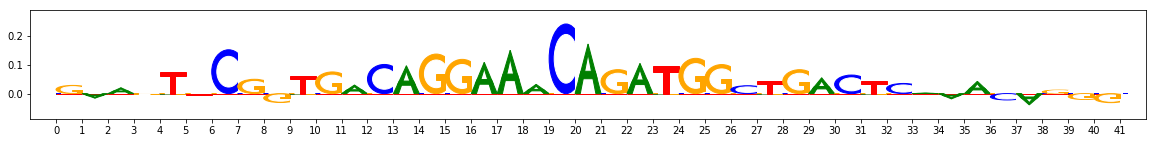

0.917329399983901 True 1.225612598564476


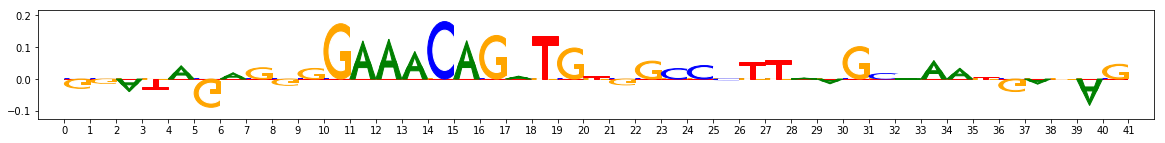

0.9156136758007286 True 1.682488302735146


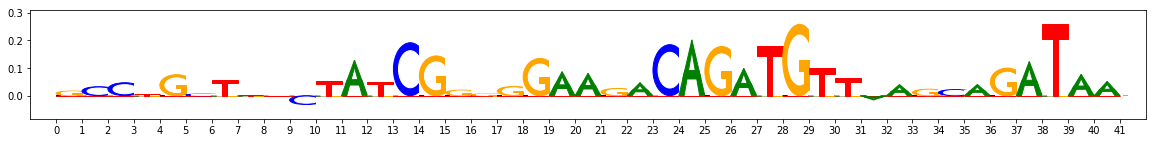

0.913234432257116 True 1.7712631383445114


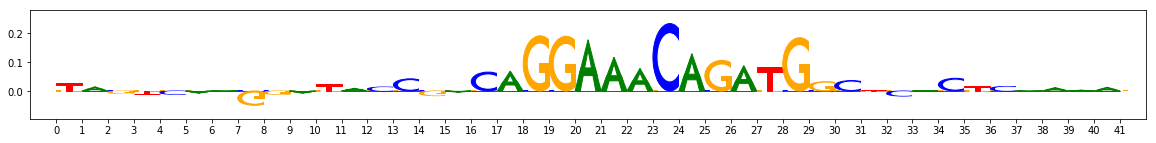

0.888383844649843 False 1.612739116093144


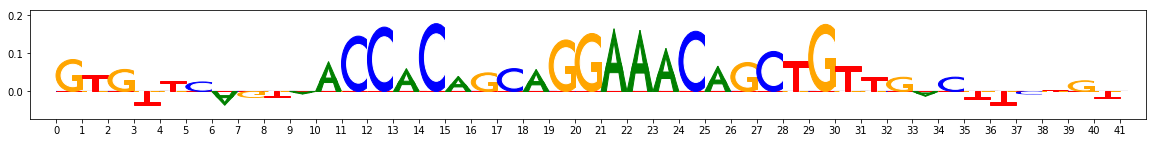

0.882709548505374 True 1.280429589212872


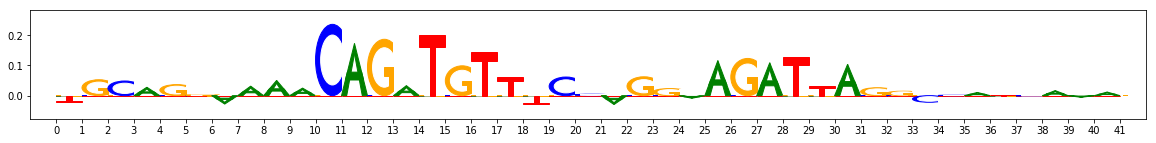

0.8808973007601641 False 0.6458823417779058


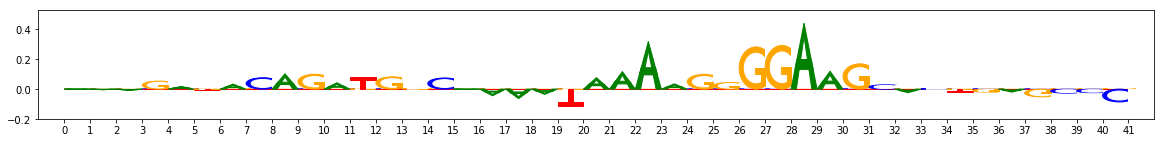

0.8747836737600836 False 0.9859600747819058


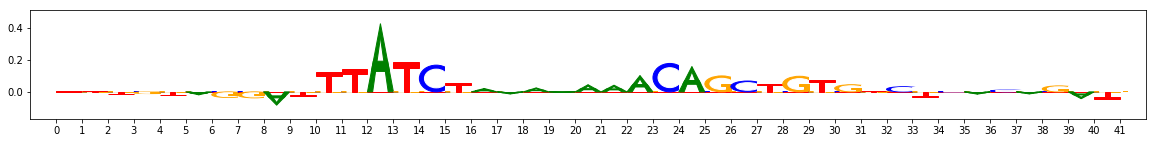

0.8723779235628001 True 0.7301490512210875


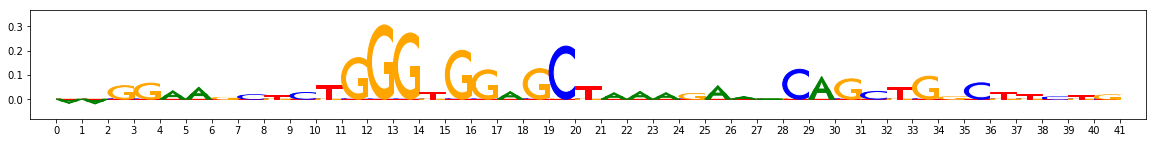

0.862542075502762 True 1.1735899321036414


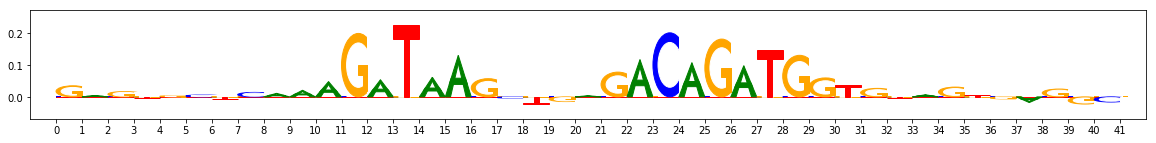

0.8624256443879125 True 1.2560193976853042


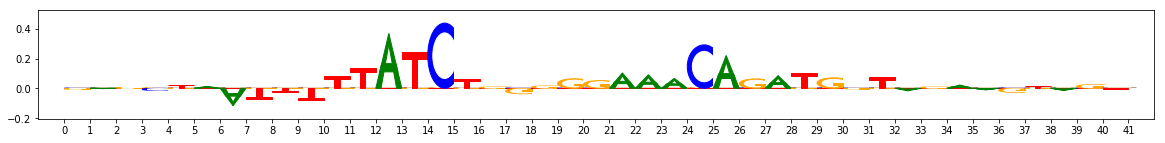

0.8624245065506938 False 0.45661748826969417


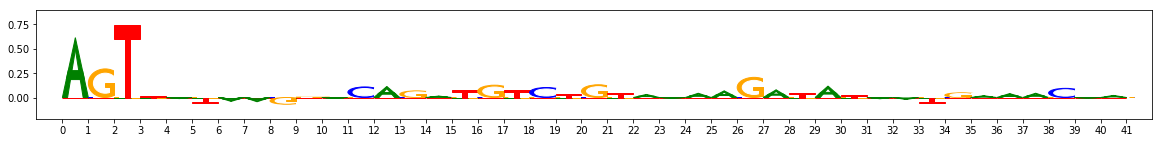

0.8591260856977637 False 1.3352195519721137


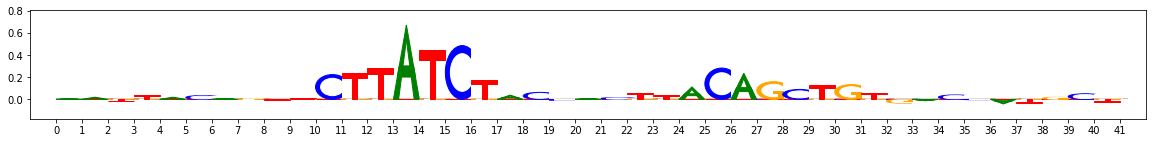

0.8588950300010085 False 1.8925061790039766


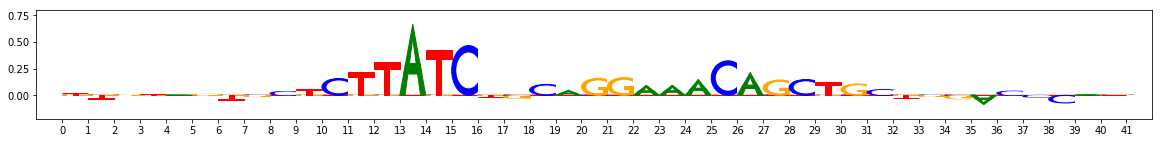

0.8584609311944671 False 1.0609885835321622


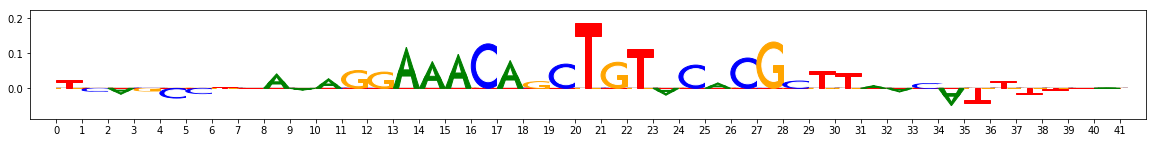

0.8567588706938986 True 0.898557538120076


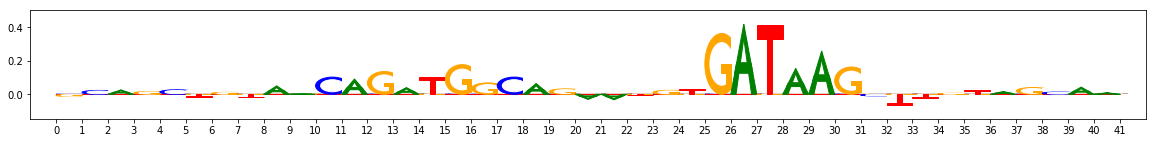

0.8563364787564611 False 1.1266766249202191


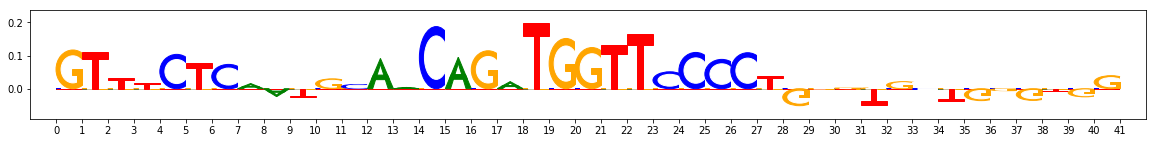

0.8488913671034455 True 0.5409325704560616


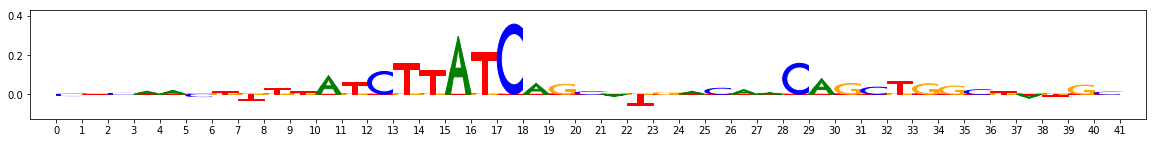

0.8485782788805999 False 0.48465701648965476


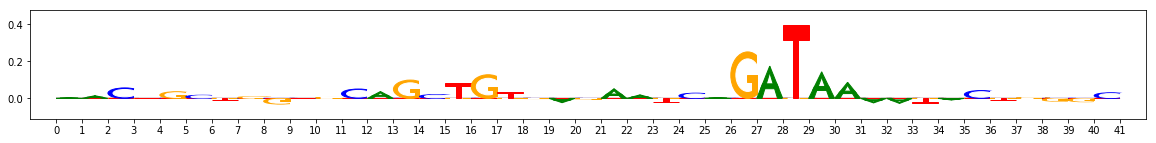

0.8483745565285423 True 0.9654534919012805


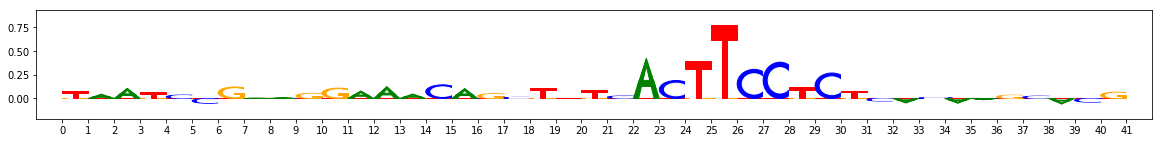

0.8479215842285195 False 0.9405016520409845


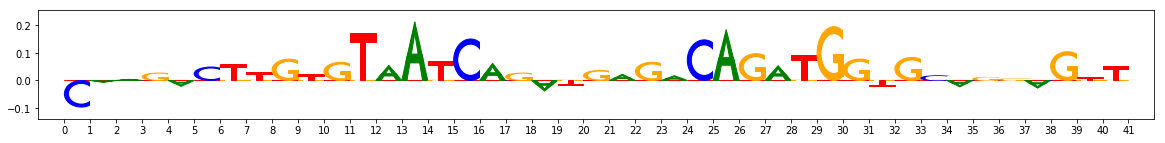

0.8466895878763975 True 0.680447663506493


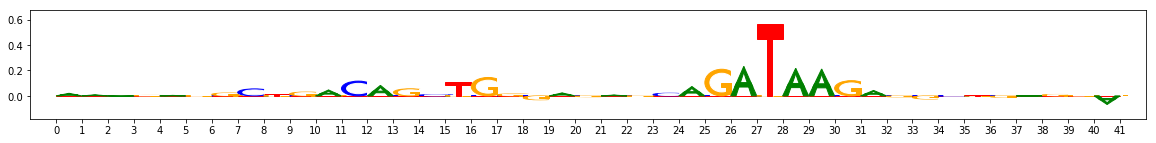

0.8419300840099765 False 0.6301940064295195


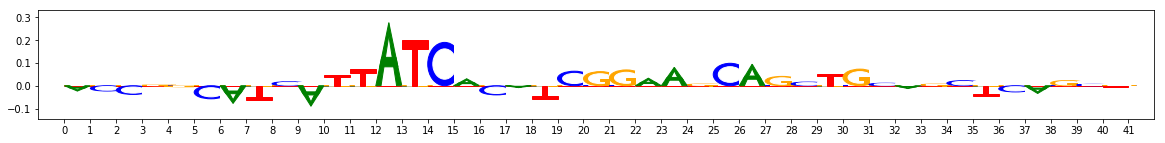

0.8400750579920804 False 0.9702993669663557


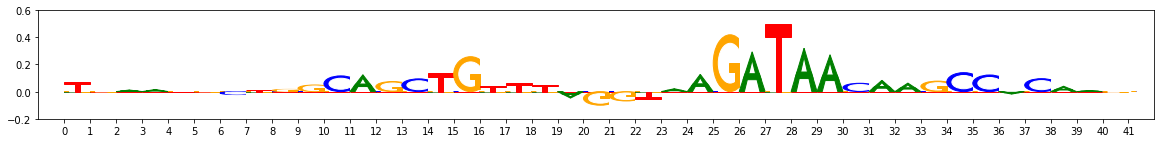

0.8400750579920804 False 0.9702993669663557


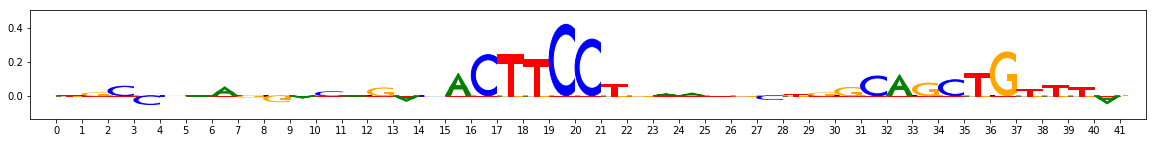

0.8395163746226153 True 0.5400305961375124


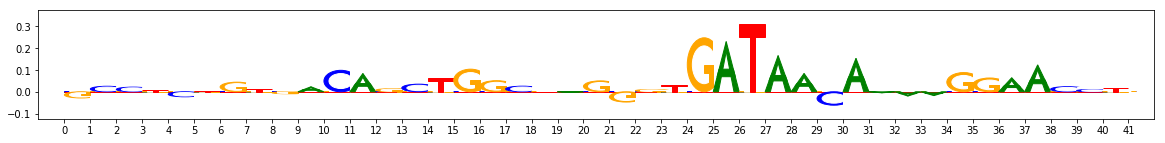

0.8373210518614105 False 0.4170835885219277


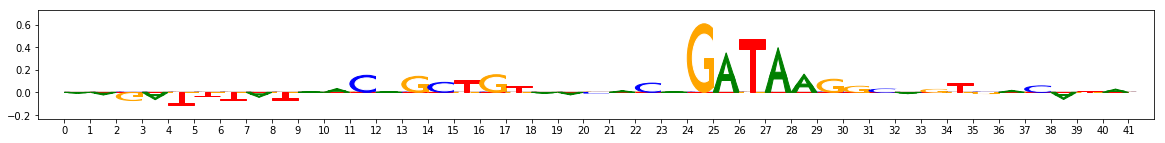

0.8323325565291777 False 0.36358203707495707


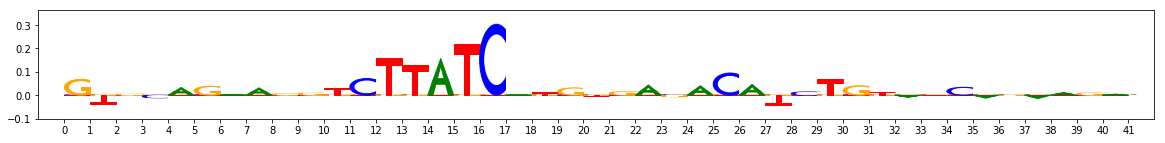

0.8307414630021096 False 0.45831671464256946


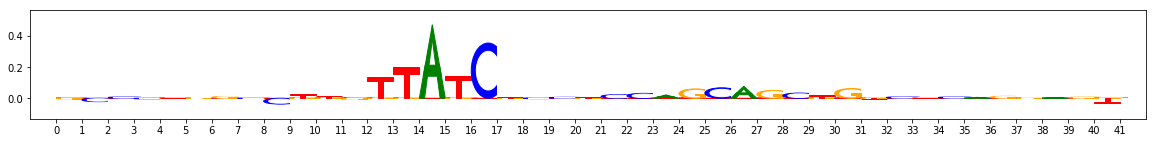

0.8292184616675393 False 0.5475510113872588


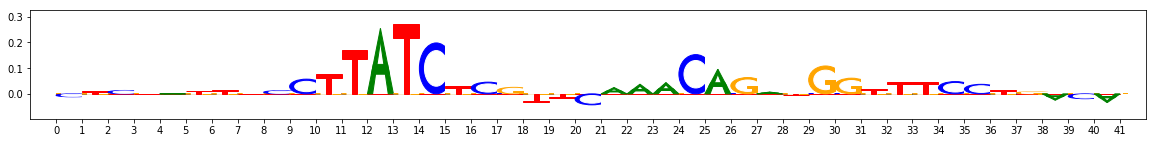

0.8289749307544324 False 0.8910449210554362


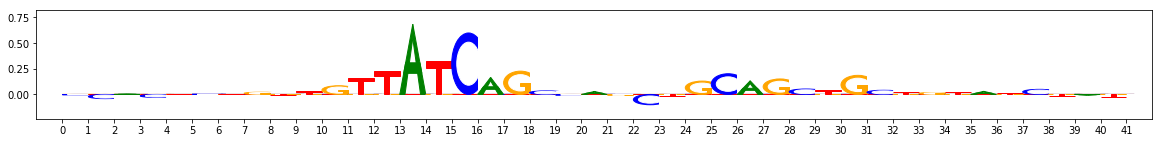

0.8203927293688456 True 0.7926490309881047


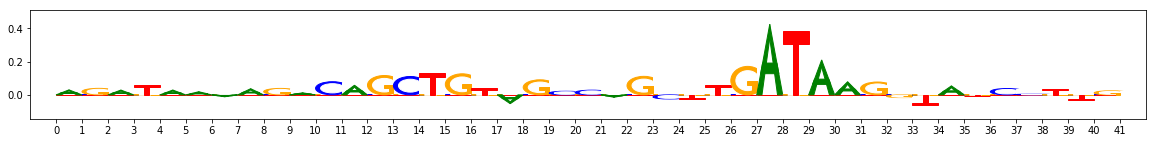

0.8197174180792184 False 0.6986513253068551


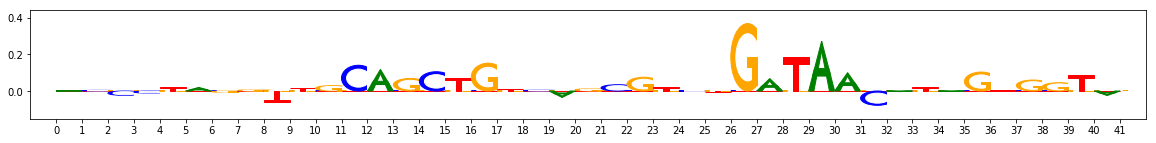

0.8186378192830301 True 0.640592298307456


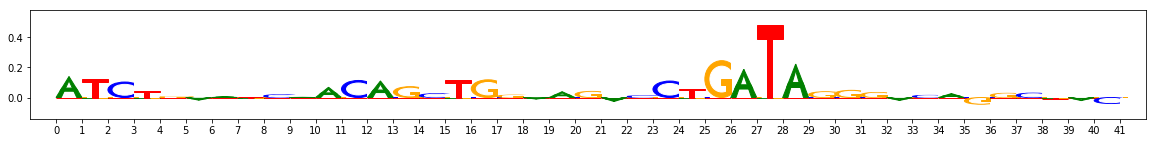

0.8177029029631929 False 1.6700694797793403


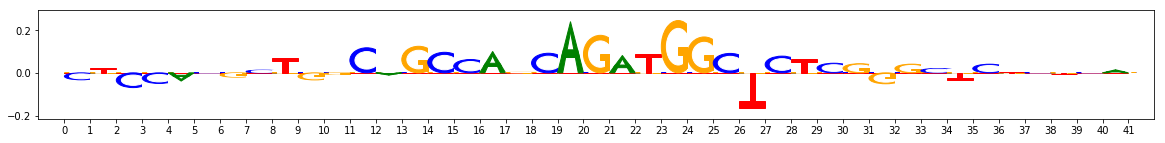

0.8161957408712851 True 1.3286651207483373


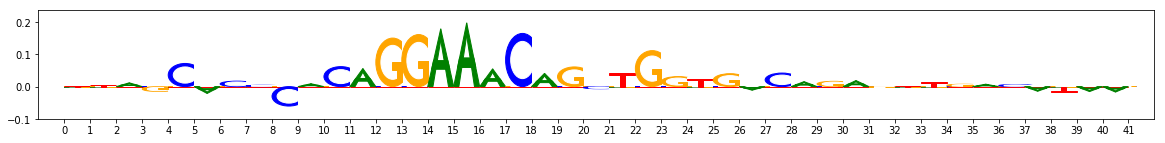

0.8143775766885691 False 0.6092104835552163


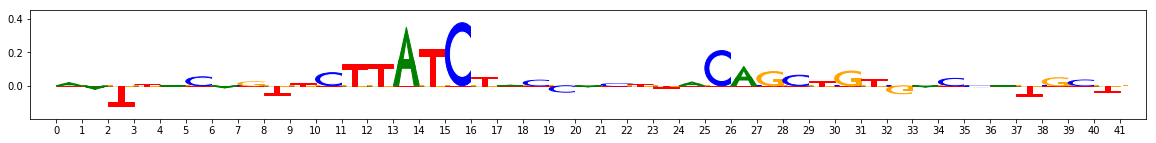

0.8128961833323866 True 0.44941615359857673


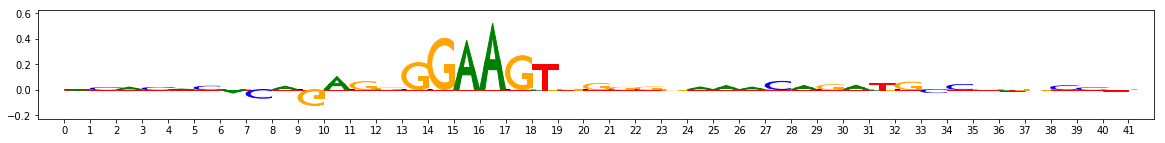

0.8127861742811291 False 0.3583836906822398


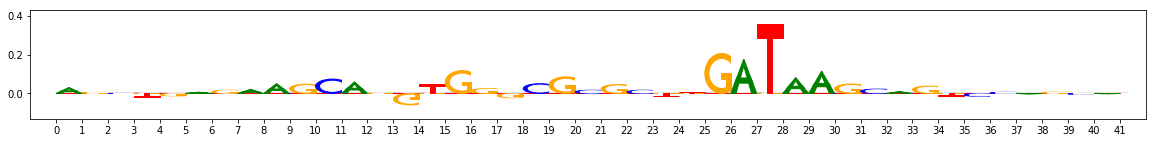

0.8100855299816564 False 0.5714470330509357


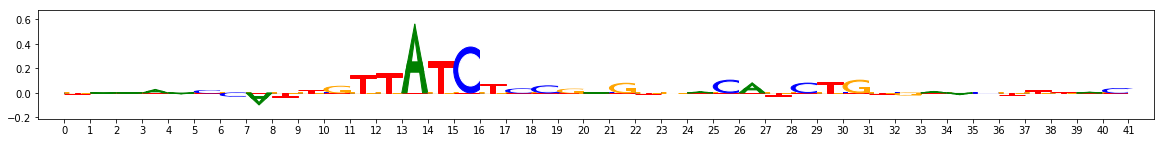

0.8082959343785712 True 0.6978292159852573


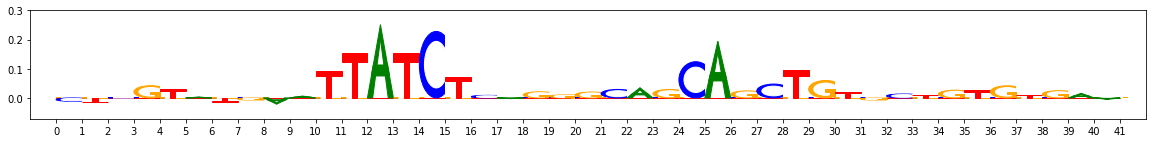

0.8078268374384187 False 1.077426431584172


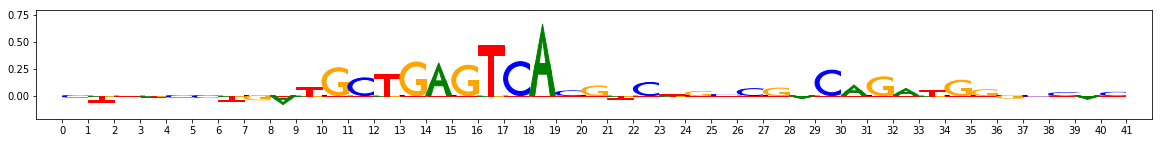

0.8066886018420264 True 1.3500345397042108


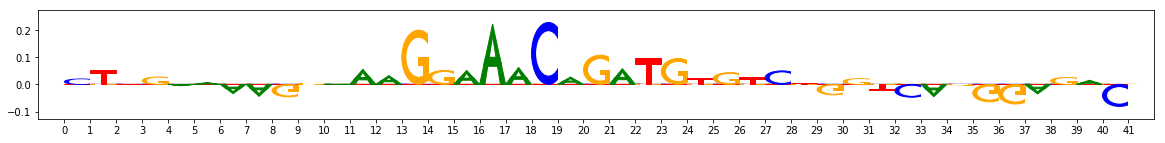

0.8044285383517339 False 0.4782871484523639


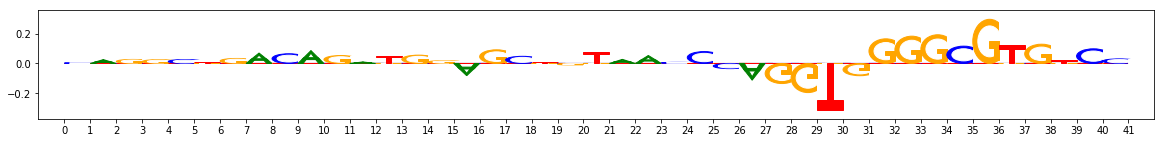

0.8041865274720916 True 0.9643440359679516


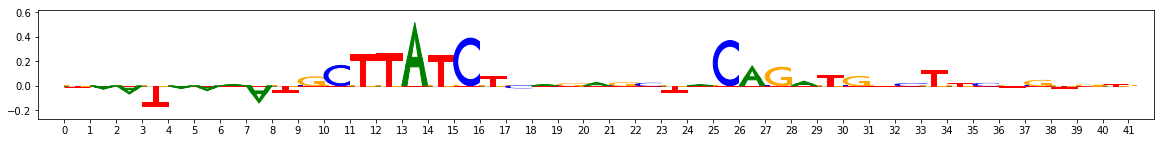

0.8039443366338367 False 0.996127808932215


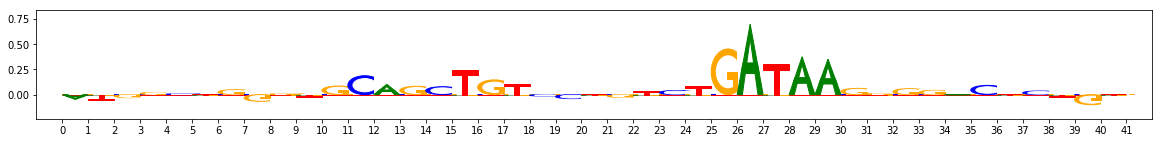

0.8030248993599621 True 0.4600167092401534


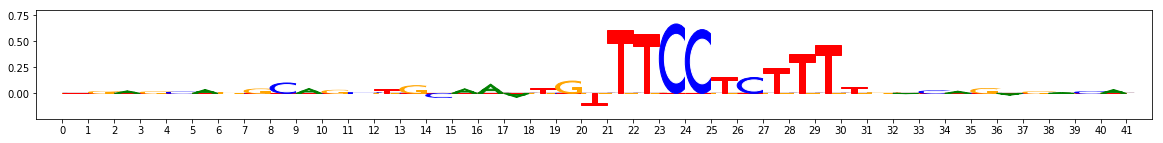

0.802707117161216 True 1.4998359520453959


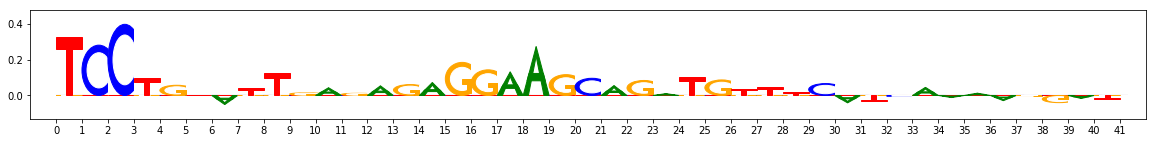

0.8007787532194148 False 0.6421282664581668


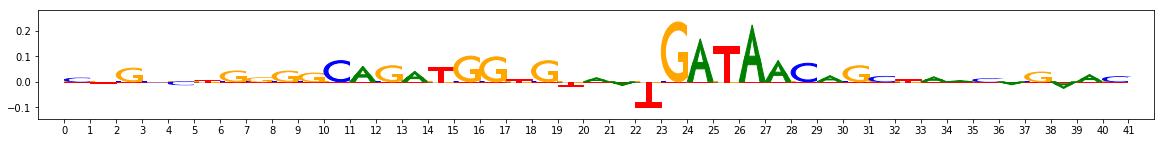

0.8004846910815079 False 0.41132064323173834


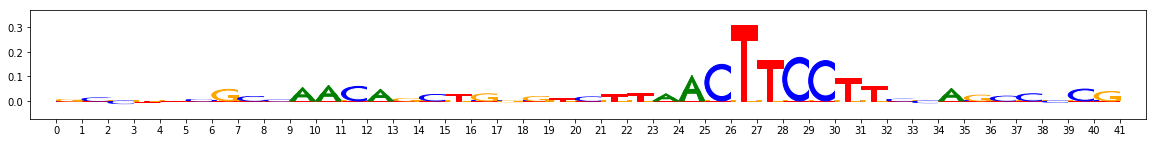

In [87]:
sorted_seqlet_indices = [x for x in
                         sorted(enumerate(combined_max_masked_cosine_sim), key=lambda x: -x[1])
                         if x[1] > 0.8]
for idx,cosinesim in sorted_seqlet_indices[:]:
    print(cosinesim, takefwd[idx], combined_totalimp_at_argmaxcosinesim[idx])
    seqlet = tfmodisco_results.multitask_seqlet_creation_results.final_seqlets[idx]
    if (takefwd[idx]):
        modisco.visualization.viz_sequence.plot_weights(seqlet["task_contrib_scores"].fwd)
        #modisco.visualization.viz_sequence.plot_weights(seqlet["task_hypothetical_contribs"].fwd)
    else:
        modisco.visualization.viz_sequence.plot_weights(seqlet["task_contrib_scores"].rev)
        #modisco.visualization.viz_sequence.plot_weights(seqlet["task_hypothetical_contribs"].rev)

In [57]:
tal_pwm_scores = pwm_scan(array=sequence_onehot, pwm=TAL1_hocomoco_pwm)
importance_in_windows, motif_cosine_sim = scan_deeplift_scores_with_pwm(
    imp_scores=imp_scores,
    pwm=TAL1_hocomoco_pwm)

/users/avanti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [58]:
from collections import OrderedDict
important_windows = OrderedDict()
sorted_tal_hits = OrderedDict()
for thresh in [0.5]:
    important_windows[thresh] = np.nonzero(importance_in_windows > thresh)
    #sort primarily by TAL hit score, secondarily by importance
    sorted_tal_hits[thresh] = sorted(sorted(zip(importance_in_windows[
              important_windows[thresh][0], important_windows[thresh][1]], 
             motif_cosine_sim[important_windows[thresh][0], important_windows[thresh][1]],
             important_windows[thresh][0],
             important_windows[thresh][1]),
            key=lambda x: -x[0]),
             key=lambda x: -x[1])

In [ ]:
for thresh in important_windows:
    print("Plotting top TAL hits where total importance at the motif exceeds",thresh)
    for idx in range(5):
        example_idx = sorted_tal_hits[thresh][idx][2]
        motif_start = sorted_tal_hits[thresh][idx][3]
        print(example_idx, motif_start, sorted_tal_hits[thresh][idx][1])
        ex_coords = example_idx_to_coords[example_idx]
        print("coords",ex_coords)
        flank=40
        viz_sequence.plot_weights(imp_scores[example_idx,
                                             motif_start-flank:
                                             motif_start+(flank+len(TAL1_hocomoco_pwm))],
                                  highlight={'red':[(flank,flank+len(TAL1_hocomoco_pwm))]},
                                  subticks_frequency=10)
        viz_sequence.plot_weights(imp_scores[example_idx],
                                             #motif_start-flank:
                                             #motif_start+(flank+len(TAL1_hocomoco_pwm))],
                                  highlight={'red':[(motif_start,motif_start+len(TAL1_hocomoco_pwm))],
                                             'blue': ex_coords,
                                             #'green': ex_coords_2
                                            },
                                  subticks_frequency=20)

In [68]:
len([hit for hit in sorted_tal_hits[thresh] if hit[1] > 0.8]) #this was only one strand but still

42

num seqlets 7675


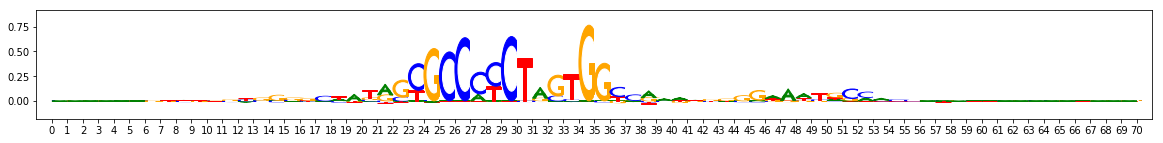

num seqlets 6372


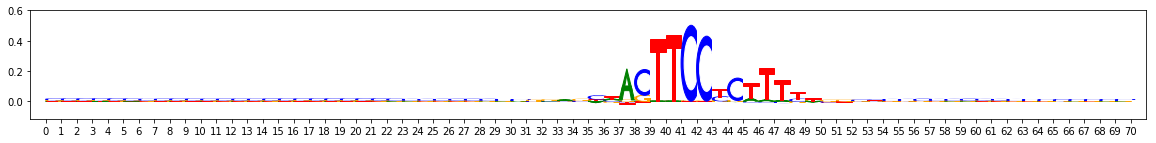

num seqlets 2645


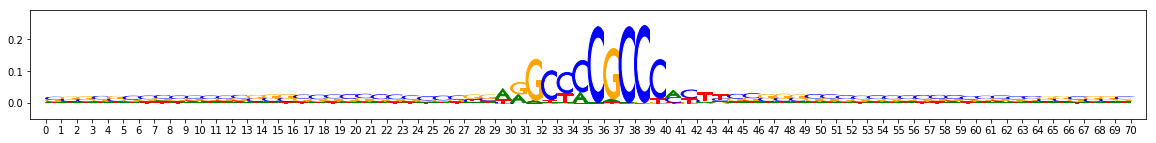

num seqlets 1077


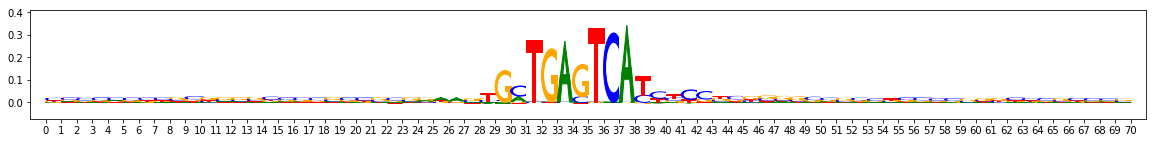

num seqlets 988


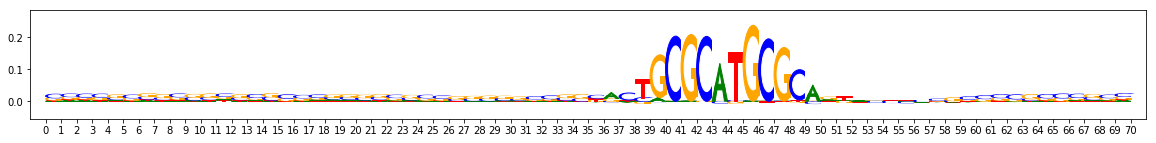

num seqlets 986


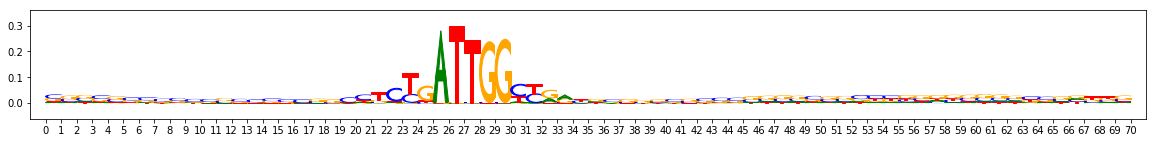

num seqlets 981


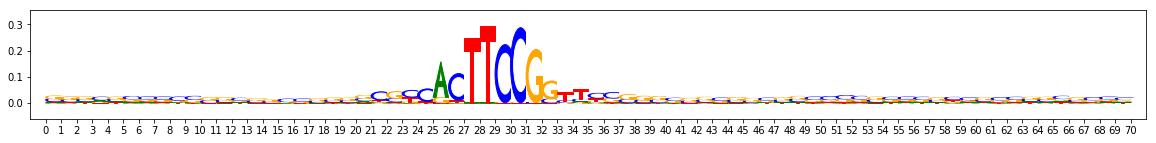

num seqlets 883


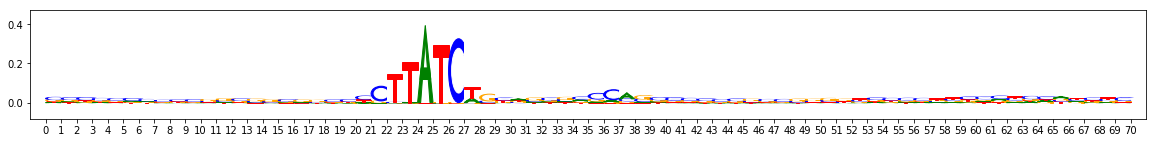

num seqlets 605


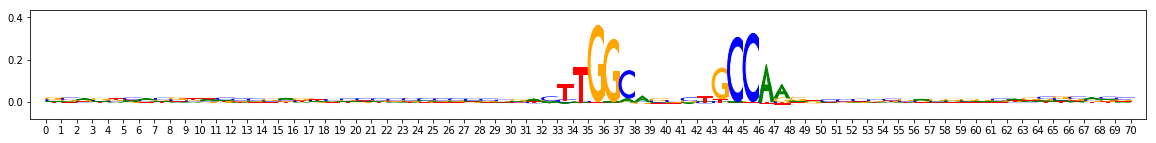

num seqlets 556


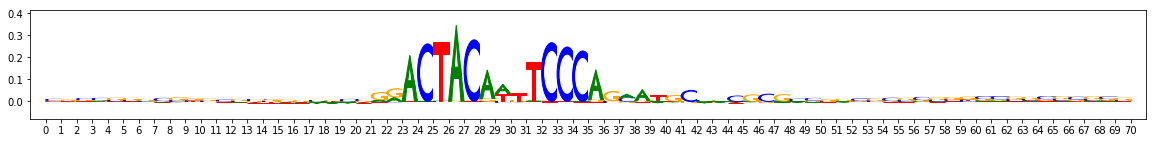

num seqlets 404


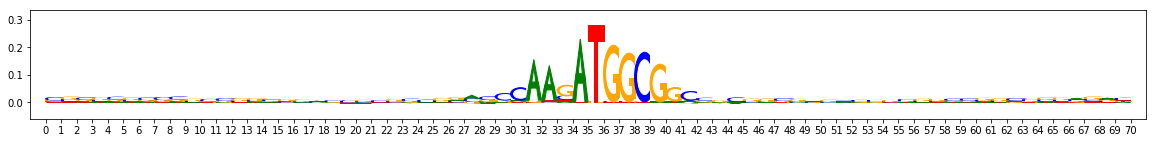

num seqlets 368


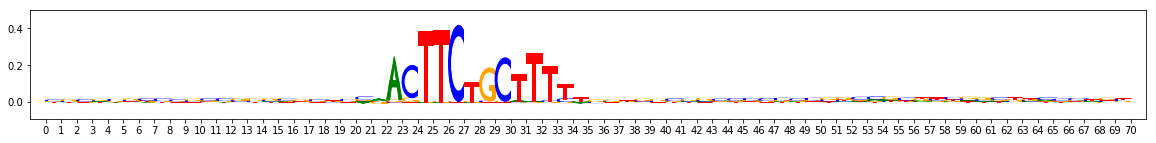

num seqlets 341


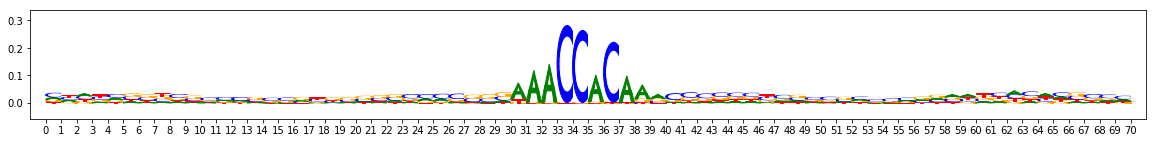

num seqlets 239


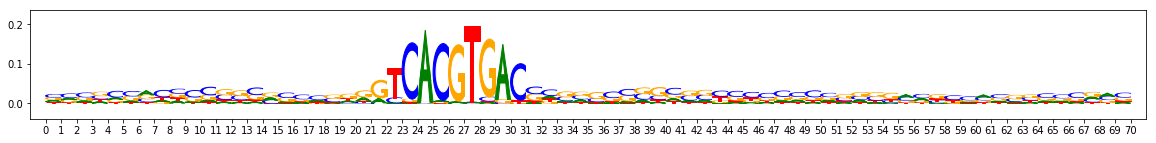

num seqlets 228


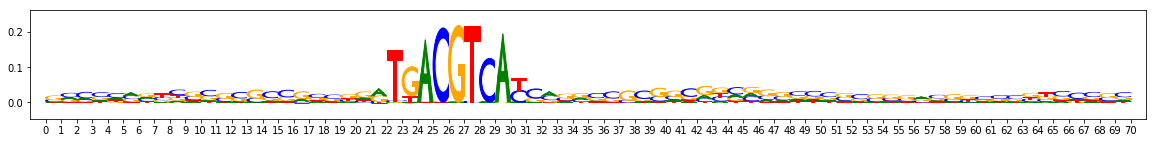

num seqlets 189


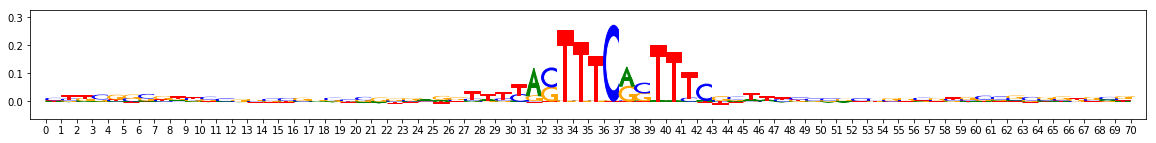

num seqlets 168


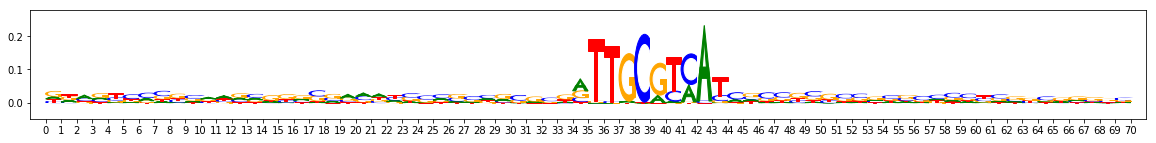

num seqlets 117


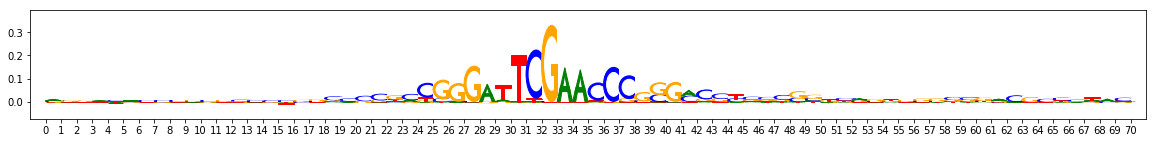

num seqlets 64


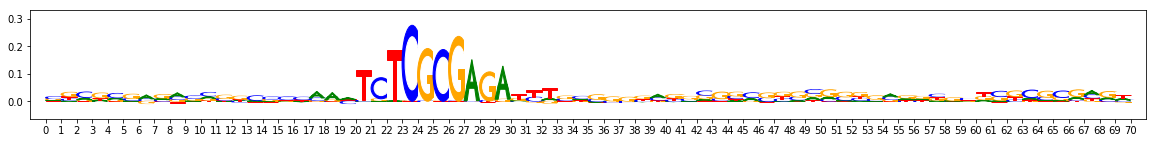

num seqlets 51


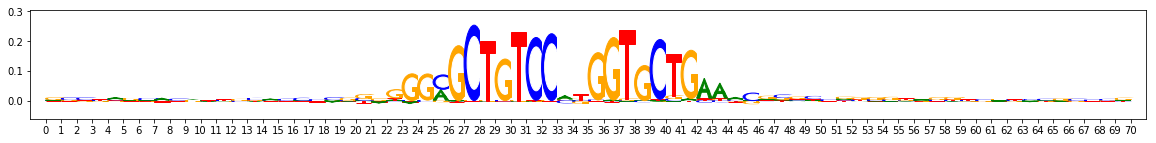

In [83]:
#visualize the motifs

patterns = tfmodisco_results.metacluster_idx_to_submetacluster_results['metacluster_1'].seqlets_to_patterns_result.patterns
for pattern in patterns:
    print("num seqlets", len(pattern.seqlets))
    modisco.visualization.viz_sequence.plot_weights(pattern["task_contrib_scores"].fwd)